<a href="https://colab.research.google.com/github/zealtechlab/crack_detection_samples-_new/blob/master/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_path = '/content/train'
valid_path = '/content/val'
test_path = '/content/test'
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['santa', 'not_santa'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['santa', 'not_santa'], batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['santa', 'not_santa'], batch_size=32)

Found 10 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


ValueError: ignored

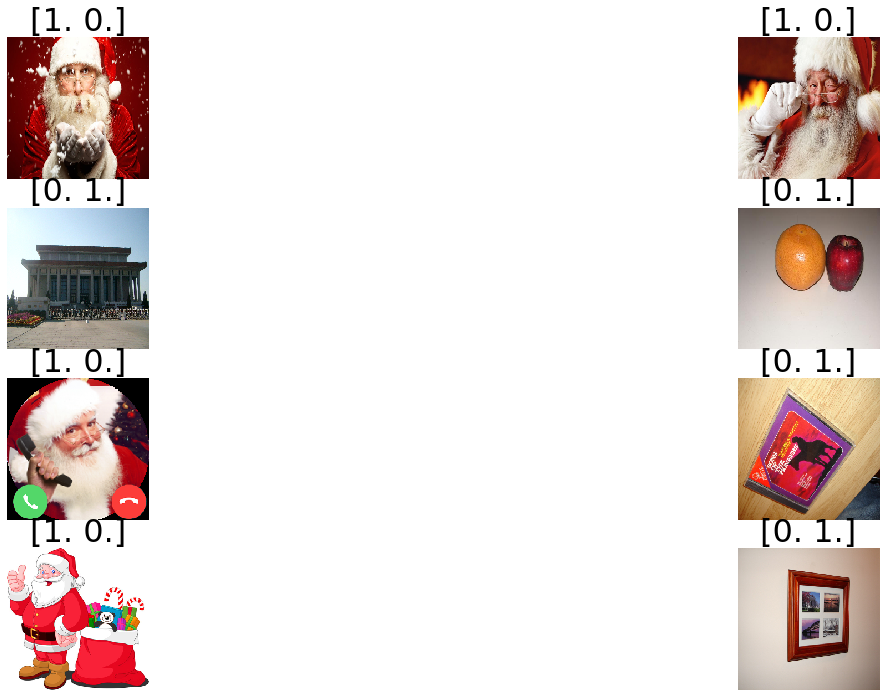

In [ ]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(24,12), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [ ]:
vgg16_model = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg16_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history = model.fit_generator(
      train_batches,
      steps_per_epoch=train_batches.samples/train_batches.batch_size ,
      epochs=5,
      validation_data=valid_batches,
      validation_steps=valid_batches.samples/valid_batches.batch_size,
      verbose=1)

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
test_imgs, test_labels = next(test_batches)
predictions = model.predict(test_imgs)

In [ ]:
import pandas as pd
def to_label(value):
    if value==0:
        return 'santa'
    else:
        return 'not_santa'
test_imgs, test_labels = next(test_batches)
predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:,1]
df['predicted'] = np.round(predictions[:,1])
df['predicted_labels']=df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, titles=df['predicted_labels'])